# Introduction

Pulsars are high-energy neutron stars that emit beams of electromagnetic radiation through their magnetic poles in regular pulses. They rotate on an axis at defining speeds. In our particular data set, the HTRU2 Data Set, which describes a sample of pulsar candidates, we are discussing 8 main variables that describe each pulse/emitted energy at a time. The first 4 variables are from the integrated pulse profile and the last 4 are from the DM-SNR Curve. Integrated Pulse Profile is the integrated signal sent by the pulsar considered with respect to rotational period. DM-SNR Curves are curves used to describe pulsars considering their frequency, phase, time and sound to noise ratio. The question we are answering is: **Which of a pulsar candidate's characteristics best indicates whether it is a pulsar star or not?**

# Preliminary Exploratory Data Analysis

The dataset can be read from the web to R and tidied as follows:

In [1]:
library(tidyverse)
library(tidymodels)
htru_data <- read_csv(
    "https://github.com/Bruce0517/dsci-100-2022w1-group-160/raw/main/HTRU_2.csv", 
    col_names = c("p.mean", "p.sd", "p.kurt", "p.skew",
                  "c.mean", "c.sd", "c.kurt", "c.skew", "class")) |>
    mutate(class = ifelse(class == 1, "Pulsar", "Non-pulsar")) |>
    mutate(class = as_factor(class))

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

The data did not have column names, so column names needed to be added. The class name was then made more human-readable and made a factor, to make data analysis easier.

The data is a description of data gathered from pulsar candidates. Here is a sample of some pulsars and non-pulsars:

In [2]:
set.seed(69420)
bind_rows(sample_n(filter(htru_data, class == "Non-pulsar"), 3),
          sample_n(filter(htru_data, class == "Pulsar"), 3))

p.mean,p.sd,p.kurt,p.skew,c.mean,c.sd,c.kurt,c.skew,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
100.14844,41.15787,0.6187296,1.5244102,1.732441,16.48696,12.498927,168.368092,Non-pulsar
110.16406,40.31318,0.5820537,0.7071917,3.343645,18.43795,8.038802,81.182894,Non-pulsar
131.17969,48.99863,0.0702603,-0.1755943,14.413880,43.49945,3.073368,8.639341,Non-pulsar
100.39844,39.28369,0.3695178,0.9012783,2.649666,21.38761,8.520892,74.554360,Pulsar
58.78906,33.07724,2.8263069,15.0398616,17.257525,54.34239,3.192879,9.012004,Pulsar
65.78125,45.98946,2.5732238,7.6958315,18.548495,52.68814,3.005062,8.190395,Pulsar


The data is then separated into training and testing sets:

In [3]:
set.seed(69420)

htru_split <- initial_split(htru_data, prop = .8, strata = class)  
htru_train <- training(htru_split)   
htru_test <- testing(htru_split)

Here is the number of pulsars and non-pulsars in the training set and the average for each variable:

In [4]:
htru_train |>
    group_by(class) |>
    summarize(n = n(), p.mean = mean(p.mean), p.sd = mean(p.sd), p.kurt = mean(p.kurt), p.skew = mean(p.skew),
                       c.mean = mean(c.mean), c.sd = mean(c.sd), c.kurt = mean(c.kurt), c.skew = mean(c.skew))

class,n,p.mean,p.sd,p.kurt,p.skew,c.mean,c.sd,c.kurt,c.skew
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Non-pulsar,13025,116.6215,47.33444,0.2090326,0.3782325,8.880065,23.30449,8.862873,113.8671
Pulsar,1293,56.6905,38.68421,3.1440269,15.7029792,50.746641,56.75291,2.693285,17.2914


The `na.rm = TRUE` argument was not required in `mean`, meaning that there are no missing values to handle. The following is a histogram for each variable from a sample of 1000 of each class, to compare the distributions of the predictor variables:

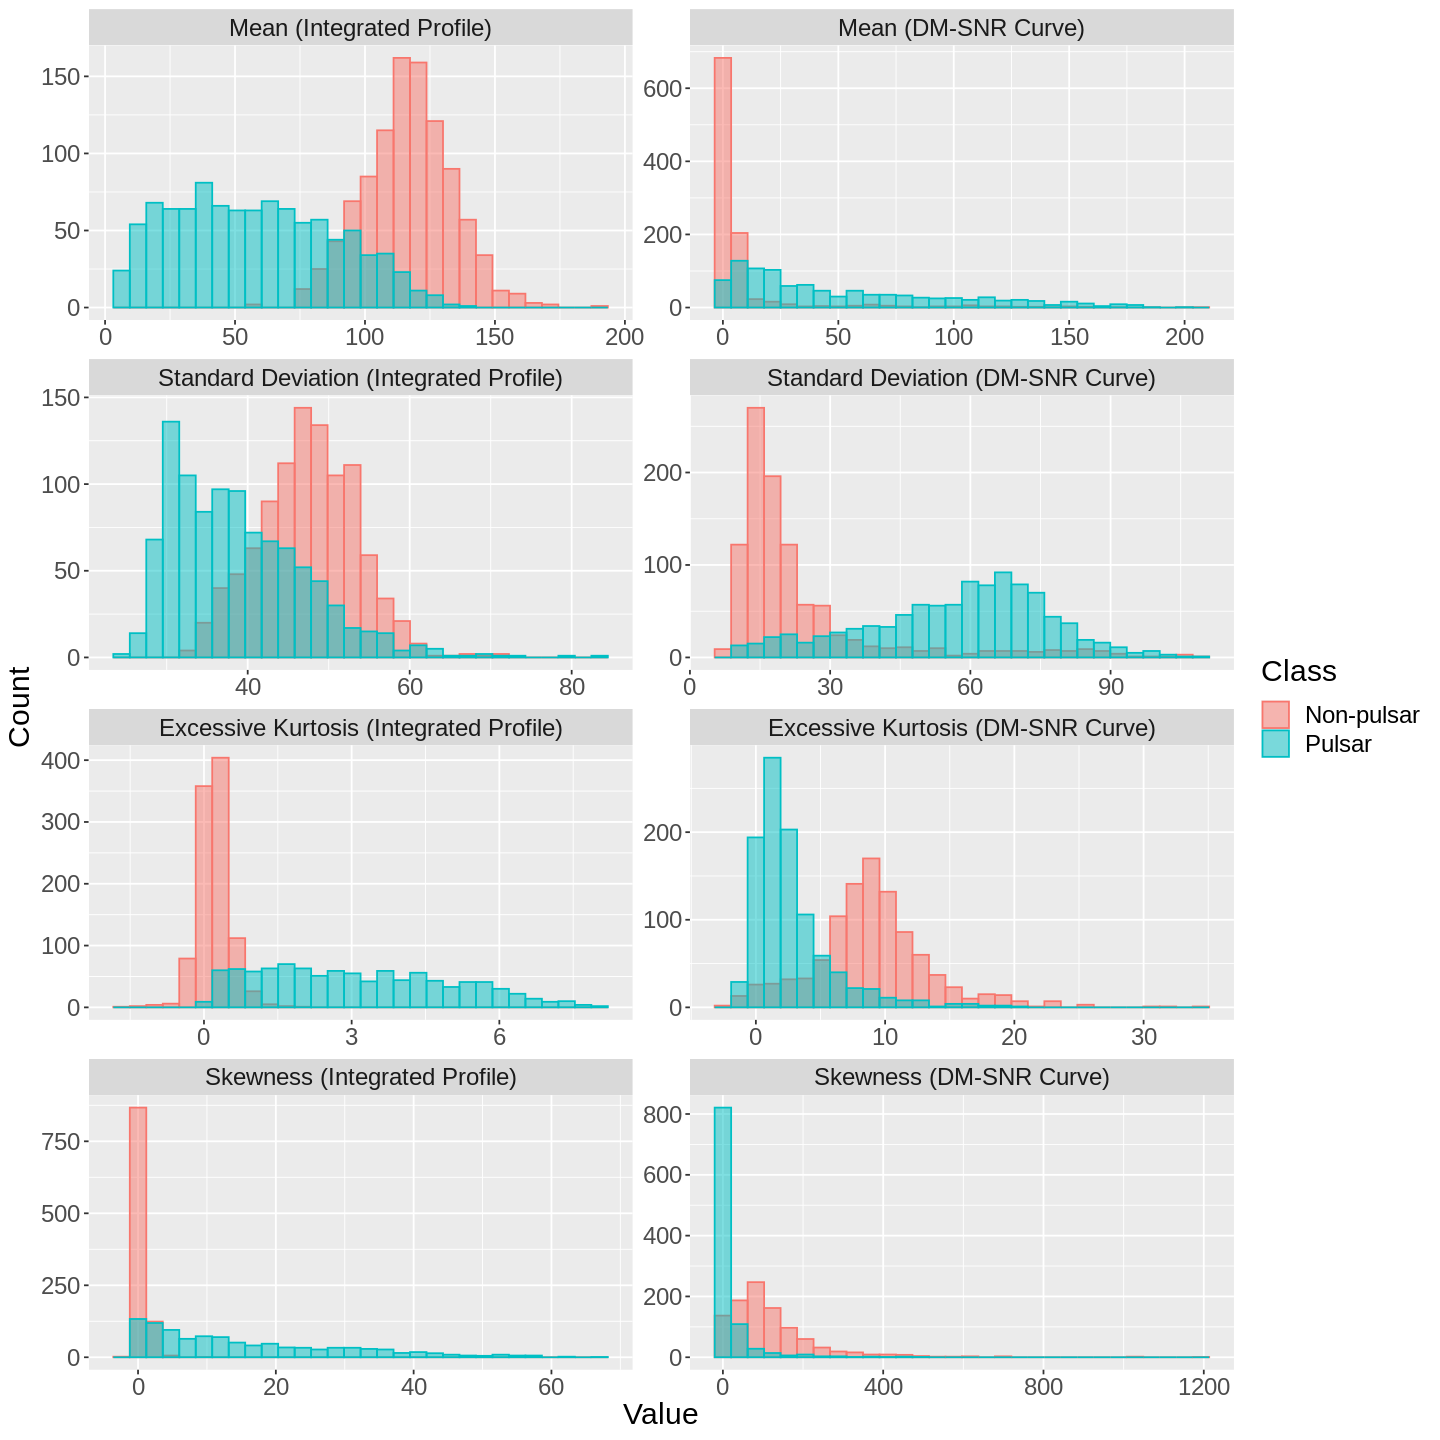

In [5]:
options(repr.plot.width=12, repr.plot.height=12)
set.seed(69420)

factor_levels <- c("p.mean", "c.mean", "p.sd", "c.sd", "p.kurt", "c.kurt", "p.skew", "c.skew")
untidy <- function(data) {  # To plot the data we must first untidy it
    data |>
    pivot_longer(-class, names_to = "preds", values_to = "vals") |> 
    mutate(preds = factor(preds, levels = factor_levels))
}
pulsar_sample <- untidy(filter(htru_train, class == "Non-pulsar") |> sample_n(1000))
non_pulsar_sample <- untidy(filter(htru_train, class == "Pulsar") |> sample_n(1000))
histo_data <- bind_rows(pulsar_sample, non_pulsar_sample)
facet_labels <- c("p.mean" = "Mean (Integrated Profile)", 
                  "p.sd" = "Standard Deviation (Integrated Profile)", 
                  "p.kurt" = "Excessive Kurtosis (Integrated Profile)", 
                  "p.skew" = "Skewness (Integrated Profile)",
                  "c.mean" = "Mean (DM-SNR Curve)", 
                  "c.sd" = "Standard Deviation (DM-SNR Curve)", 
                  "c.kurt" = "Excessive Kurtosis (DM-SNR Curve)", 
                  "c.skew" = "Skewness (DM-SNR Curve)")

ggplot(histo_data, aes(x = vals, fill = as_factor(class), color = as_factor(class))) +
    geom_histogram(alpha = 0.5, position = "identity", bins = 30) +
    facet_wrap(vars(preds), nrow = 4, ncol = 2,
               scales = "free", 
               labeller = as_labeller(facet_labels)) +
    labs(x = "Value", y = "Count", fill = "Class", color = "Class") +
    theme(text = element_text(size=18))

The plots show that most values do not have a significant overlap between classes, and thus patterns can be identified in the data which will support further analysis of this data done to answer the question.

# Methods

To conduct the data analysis required to answer the devised question, all of the variables will be used. Importantly, the class variable indicates whether the candidate is a pulsar or not; the remaining variables describe important and unique properties of the candidates. The data analysis will be conducted using classification, which allows us to predict the class for a pulsar candidate. The intended methodology for this data analysis is to test and train models of the data for each of the numerical variables, to determine which variable is most accurate in predicting the class of pulsar candidates. 

This data will be visualized in various ways to ensure its implications can be communicated. One way the results will be visualized will be through bar plots, which could be used for the comparison of accuracies. As the results of this data analysis become more evident, more ways to effectively visualize the results will also become apparent.

# Expected Outcomes and Significance

From the preliminary data analysis, it is apparent that the numerical variables have notable differences in their distributions; which indicates that it is likely a sound conclusion will be made from the data analysis. It is expected that there will not be a clear result that will not need its limitations to be discussed thoroughly. From the preliminary data analysis, there is no hypothesis that can be made with a great deal of confidence.

It is unlikely that the findings of our data analysis will be ground-breaking and have implications on the communities of learners and teachers that are closely engaged with the minutia surrounding astronomical bodies. However, our findings will definitely have the impact of enforcing the idea that data science can influence our underst anding of the way nature behaves with itself. These findings can lead to future questions about the significance of applying new ideas to pre existing understandings to create more opportunities for breakthroughs in the way humans interact with nature.
